# Cyber security for healthcare via reinforcement learning

DeepGuard Inc., a leading cybersecurity company for healthcare industries, is facing an increase in the complexity and sophistication of cyberattacks. The need to protect sensitive patient information and ensure regulatory compliance is crucial to maintaining customer trust and data security.

**Project benefits:** implementing advanced reinforcement learning algorithms to simulate and mitigate attack and defense scenarios offers significant benefits:

- **Defense improvement:** training defensive agents in simulated scenarios to develop robust and adaptable protection strategies.
- **Vulnerability identification:** simulation of attacks to identify and resolve vulnerabilities in network systems before they can be exploited by real attackers.
- **Technological innovation:** using advanced reinforcement learning techniques to foster innovation and continuously improve cyber defense capabilities.
- **Resource optimization:** automate attack and defense simulation to reduce human workload and optimize enterprise resource allocation.

**Project details:** GreenGuard Solutions commissioned the development of an advanced cybersecurity solution based on Reinforcement Learning algorithms. The project focuses on the application of two main algorithms within the gym-idsgame environment, which specializes in attack and defense simulations in computer networks.

**Project goals:**

1. **SARSA algorithm:** use SARSA to address "random attack" scenarios in the gym-idsgame environment.
2. **DDQN algorithm:** implement Double Deep Q-Network (DDQN) with PyTorch to solve "random attack" and "maximal attack" scenarios.

**Deliverable:** the project requires the delivery of a Google Colab notebook divided into two main sections, each dedicated to one of the two Reinforcement Learning algorithms. Each section should contain detailed explanations of the proposed solutions, justifying the choices made and analyzing the results obtained.

**Project reason:** GreenGuard Solutions places the highest priority on cybersecurity in the healthcare industry. Using advanced Reinforcement Learning algorithms to simulate and mitigate cyber risks allows the company to strengthen its defensive capabilities and protect computer networks against increasingly sophisticated attacks. By automating attack simulation, GreenGuard optimizes operational efficiency and confirms itself as a leader in cybersecurity technology innovation in the healthcare industry.

**Link to the simulation environment:** https://github.com/Limmen/gym-idsgame

With this project, GreenGuard Solutions aims to ensure the security of sensitive patient data and maintain the integrity of information in the healthcare context, protecting computer networks from increasingly advanced and persistent cyber threats.

# Environment set up

In [ ]:
# Importing libraries
from collections import defaultdict, deque, namedtuple
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from typing import Optional
import gymnasium as gym
import torch.nn as nn
import networkx as nx
import pandas as pd
import numpy as np
import warnings
import random
import pickle
import torch
import os

# To ignore all warnings
warnings.filterwarnings('ignore')

**IMPORTANT**

*To make the enivironment work correctly it's necessary to apply the following patches to the source code, since the gym-idsgame library is not immediately compatible with the versions of gymnasium and other packages used in this project.*

*The following codeblock automate the entire process of downloading, installing and then correcting the library.*

In [ ]:
def setup_environment():

    print('Environment set up')
    if not os.path.exists('gym-idsgame'):
        !git clone https://github.com/Limmen/gym-idsgame

    %cd gym-idsgame
    !pip install -q -e .
    print('Environment installed successfully')

def apply_patches():

    print('Applying patches')

    patches = [
        {
            'id': 'Patch 1 (NameError)',
            'file': 'gym_idsgame/agents/bot_agents/random_attack_bot_agent.py',
            'type': 'inject',
            'anchor': 'def is_attack_legal(self, action, obs, game_state):',
            'content': '        from gym_idsgame.envs.util import idsgame_util'
        },
        {
            'id': 'Patch 2 (TypeError)',
            'file': 'gym_idsgame/envs/idsgame_env.py',
            'type': 'replace',
            'anchor': 'def reset(self, seed: int = 0, update_stats = False) -> np.ndarray:',
            'content': '    def reset(self, seed: int = 0, options = None, update_stats = False) -> np.ndarray:'
        }
    ]

    for patch in patches:
        file_path = patch['file']
        if not os.path.exists(file_path):
            print(f'[{patch["id"]}] Skip: {file_path} not found')
            continue

        with open(file_path, 'r') as f:
            lines = f.readlines()

        new_content = []
        applied = False

        for line in lines:
            if patch['anchor'] in line and not applied:
                if patch['type'] == 'inject':
                    new_content.append(line)
                    new_content.append(f'{patch["content"]}\n')
                elif patch['type'] == 'replace':
                    new_content.append(f'{patch["content"]}\n')
                applied = True
            else:
                new_content.append(line)

        if applied:
            with open(file_path, 'w') as f:
                f.writelines(new_content)
            print(f"[{patch['id']}] Applied successfully")
            # Verify via grep
            !grep "{'def reset' if 'Patch 2' in patch['id'] else patch['anchor']}" {file_path}
        else:
            # Check if already patched to avoid false error messages
            with open(file_path, 'r') as f:
                if patch['content'].strip() in f.read():
                    print(f'[{patch["id"]}] Already present')
                else:
                    print(f'[{patch["id"]}] Error: Target anchor not found')

# Execution
setup_environment()
apply_patches()

# Complete library import
from gym_idsgame.envs import IdsGameEnv

Environment set up
Cloning into 'gym-idsgame'...
remote: Enumerating objects: 13908, done.
remote: Counting objects: 100% (254/254), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 13908 (delta 220), reused 206 (delta 206), pack-reused 13654 (from 2)
Receiving objects: 100% (13908/13908), 88.02 MiB | 33.77 MiB/s, done.
Resolving deltas: 100% (9652/9652), done.
/content/gym-idsgame
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 18.6 MB/s eta 0:00:00
Environment installed successfully
Applying patches
[Patch 1 (NameError)] Applied successfully.
    def is_attack_legal(self, action, obs, game_state):
[Patch 2 (TypeError)] Applied successfully.
    def reset(self, seed: int = 0, options = None, update_stats = False) -> np.ndarray:


In [ ]:
# Seed set up to ensure reproducibility
seed = 0

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [ ]:
# Check that the GPU is mounted correctly
torch.cuda.is_available()

True

In [ ]:
# Select the device to run PyTorch tensors and models on, preferring GPU (CUDA) if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Utilities

 The **choose_action** function determines which action the agent should take in a given state by generating a random number between 0 and 1 based on an epsilon-greedy policy.

 If the number is greater than epsilon, the agent exploits its current knowledge by selecting the action with the highest value in the Q-table for that state.

 If the number is less than or equal to epsilon, the agent explores by choosing a random action, which helps it discover potentially better strategies it hasn't fully mapped yet.

In [ ]:
def choose_action(state, q_table, epsilon, env):
    if random.uniform(0, 1) > epsilon:
        # Exploit: choose the action with the highest Q-value for the current state
        return np.argmax(q_table[state])
    else:
        # Explore: choose a random action from the action space
        return env.action_space.sample()

The **train_sarsa_agent** function is designed to train a reinforcement learning agent using the **SARSA (State-Action-Reward-State-Action) algorithm**.

The primary goal of this function is to fill and refine a **Q-table**, which acts as the agent's "memory" or "strategy book." By the end of the training, the Q-table tells the agent which action is likely to yield the highest long-term reward for any given state.

The function takes in the "rules of the world" (the **environment**), the "timeframe" (**episodes** and **steps**), and the "learning personality" (**hyperparameters** like gamma, epsilon, and learning rate) to produce a trained agent ready for evaluation.

In [ ]:
def train_sarsa_agent(env, episodes, max_steps, gamma,
                      epsilon, epsilon_decay, epsilon_decay_point, epsilon_end,
                      lr_start, lr_end, lr_decay):

    # Initialize Q-table
    q_table = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards_all_episodes = list()

    # Start training
    print('SARSA agent: training on "random attack" scenario\n')

    for episode in range(episodes):
        state, info = env.reset()
        state = tuple(state.flatten())
        total_episode_reward = 0

        action = choose_action(state, q_table, epsilon, env)

        for step in range(max_steps):
            next_state, reward, terminated, truncated, info = env.step((None, action))
            defender_reward = reward[1]
            next_state = tuple(next_state.flatten())

            # Choose next action (epsilon-greedy policy)
            next_action = choose_action(next_state, q_table, epsilon, env)

            # Retrieve the current Q-value for the (state, action) and (next_state, next_action) pairs
            old_value = q_table[state][action]
            next_value = q_table[next_state][next_action]

            # Calculate the TD (Temporal Difference) target for the SARSA update
            td_target = defender_reward + gamma * next_value
            # Calculate the new Q-value using the SARSA update rule
            new_value = old_value + lr_start * (td_target - old_value)
            # Update the Q-table with the new Q-value
            q_table[state][action] = new_value

            # Transition to the next state and action for the next iteration
            state = next_state
            action = next_action
            total_episode_reward += defender_reward

            # End episode if terminated (agent reached a terminal state) or truncated (max steps reached)
            if terminated or truncated:
                break

        # Decay epsilon: gradually reduce exploration over time
        if episode > epsilon_decay_point:
            epsilon = max(epsilon_end, epsilon * epsilon_decay)

        # Decay learning rate: gradually reduce the step size of updates
        lr_start = max(lr_end, lr_start * lr_decay)

        rewards_all_episodes.append(total_episode_reward)

        # Print progress and average reward every 1000 episodes
        if (episode + 1) % 1000 == 0:
            avg_reward = np.mean(rewards_all_episodes[-1000:])
            print(f'Episode: {episode + 1}/{episodes}\nAvg reward: {avg_reward:.4f}\tEpsilon: {epsilon:.4f}\tAlpha: {lr_start:.4f}')

    print('\nTraining finished')
    env.close()

    return rewards_all_episodes

The **QNetwork class** creates a neural network used in the **DDQN (Double Deep Q-Network) agent** to estimate **Q-values** for actions given a state. It helps the agent decide the best action to take based on what it *"sees"* in its environment.

In [ ]:
class QNetwork(nn.Module):

    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()

        # Layers definition
        self.input_layer = nn.Linear(state_size, 128)
        self.hidden_layer_1 = nn.Linear(128, 128)
        self.hidden_layer_2 = nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, action_size)

        # Dropout: prevents overfitting
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, state):

        # Pass data through the first layer and apply 'ReLU'
        x = F.relu(self.input_layer(state))
        x = self.dropout(x)

        # Pass through the second layer
        x = F.relu(self.hidden_layer_1(x))
        x = self.dropout(x)

        # Pass through the third layer
        x = F.relu(self.hidden_layer_2(x))

        # Output the scores for each possible action
        return self.output_layer(x)

The **ReplayBuffer class**, is a vital component inthe **DDQN reinforcement learning algorithm**. Its main purpose is to store the agent's experiences (state, action, reward, next state, and whether the episode ended) and then allow for random sampling of these experiences during training.

In [ ]:
class ReplayBuffer:

    def __init__(self, action_size, buffer_size, batch_size):

        self.action_size = action_size
        self.batch_size = batch_size

        # Deque from a list (FIFO - First In, First Out)
        self.memory = deque(maxlen=buffer_size)

        # Store memory:
        self.experience = namedtuple('Experience', field_names = ['state', 'action', 'reward', 'next_state', 'done'])

    def add(self, state, action, reward, next_state, done):
        new_memory = self.experience(state, action, reward, next_state, done)
        self.memory.append(new_memory)

    def sample(self):

        # Pick a random "batch" of experiences from the memory
        experiences = random.sample(self.memory, k=self.batch_size)

        # Convert states, actions, rewards, next_state and dones into tensors
        states = torch.from_numpy(np.vstack([e.state for e in experiences])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):

        # How many memories are currently stored
        return len(self.memory)

The following code block defines the **DDQNAgent class**, which is the central component of the DDQN implementation. It orchestrates the entire learning process by managing the neural networks, experience replay, and the interaction with the environment.

In [ ]:
# DDQN agent
class DDQNAgent():

    def __init__(self, state_size, action_size, gamma, tau, learning_rate, upd_freq, buffer_size, batch_size):

        # Initialize DDQN agent
        self.state_size = state_size
        self.action_size = action_size

        self.gamma = gamma
        self.tau = tau
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.update_every = upd_freq

        # Q-Network (local and target)
        self.qnetwork_local = QNetwork(state_size, action_size).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=learning_rate)

        # Replay memory
        self.memory = ReplayBuffer(action_size, buffer_size, batch_size)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):

        # Save experience in replay memory
        self.memory.add(state.flatten(), action, reward, next_state.flatten(), done)
        loss = None

        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                loss = self.learn(experiences, self.gamma)
        return loss

    def act(self, state, eps=0):

        # Returns an action for a given state as per the current policy
        state = torch.from_numpy(state.flatten()).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):

        # Update value parameters using a given batch of experience tuples
        states, actions, rewards, next_states, dones = experiences

        # Local network chooses the best actions in the next states
        best_actions = self.qnetwork_local(next_states).detach().max(1)[1].unsqueeze(1)

        # Target network evaluates the chosen actions
        Q_targets_next = self.qnetwork_target(next_states).detach().gather(1, best_actions)

        # Compute the Q-targets: immediate reward + discounted next state Q-value
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Predicted Q-values for the current (state, action) pairs
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Loss between predicted and target Q-values
        loss = F.mse_loss(Q_expected, Q_targets)

        # Backpropagation: reset gradients, compute new gradients and update weights
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network using the soft update function
        self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)

        return loss.item()

    def soft_update(self, local_model, target_model, tau):

        # Soft update model parameters
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

The **train_ddqn_agent function** is responsible for training the **Double Deep Q-Network (DDQN) agent** in a reinforcement learning environment.

The function takes in the "rules of the world" (the **environment**), the "timeframe" (**episodes** and **steps**), and the "learning personality" (**hyperparameters** like gamma, epsilon, and learning rate) to produce a trained agent ready for evaluation.

In [ ]:
def train_ddqn_agent(env, episodes, max_steps, epsilon, gamma, learning_rate,
                     epsilon_decay, epsilon_end, tau, upd_freq,
                     buffer_size, batch_size):

    # Agent initialization
    temp_state, _ = env.reset()
    state_size = np.prod(temp_state.shape).item()

    action_size = env.action_space.n

    agent = DDQNAgent(state_size=state_size, action_size=action_size, gamma=gamma,
                      tau=tau, upd_freq=upd_freq, learning_rate=learning_rate,
                      buffer_size=buffer_size, batch_size=batch_size)

    # Training loop
    rewards_all_episodes = list()
    losses_log = list()

    # Detect attack type from environment name
    attack_type = env_name.split('-')[1]

    # Start training
    print(f'DDQN agent training on {attack_type.replace('_', ' ')} scenario\n')
    for episode in range(1, episodes + 1):
        state, info = env.reset()
        total_episode_reward = 0

        for t in range(max_steps):
            action = agent.act(state, epsilon)
            next_state, reward, terminated, truncated, info = env.step((None, action))
            done = terminated or truncated
            defender_reward = reward[1]

            loss = agent.step(state, action, defender_reward, next_state, done)
            if loss is not None:
                losses_log.append(loss)

            state = next_state
            total_episode_reward += defender_reward
            if done:
                break

        rewards_all_episodes.append(total_episode_reward)
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        if (episode + 1) % 1000 == 0:
            avg_reward = np.mean(rewards_all_episodes[-1000:])
            print(f'Episode: {episode + 1}/{episodes}\nAvg reward: {avg_reward:.4f}')

    print('\nTraining finished')
    env.close()

    return rewards_all_episodes, losses_log

The **plot_rewards** and **plot_loss** functions are a diagnostic tool used to visualize the agent's learning progress over the course of the training session. Instead of showing the raw informations for every single episode (which is often too "noisy" to interpret) it cleans the data to reveal the underlying learning trend.

In [ ]:
def plot_rewards(rewards_list, title):

    plt.figure(figsize=(12, 6))

    # Calculate and plot a 1000-episode moving average
    rewards_moving_average = np.convolve(rewards_list, np.ones(1000)/1000, mode='valid')

    plt.plot(rewards_moving_average)
    plt.title(title)
    plt.xlabel('Episodes')
    plt.ylabel('Moving average reward')
    plt.grid(True)
    plt.show()

def plot_loss(losses_list, title):

    plt.figure(figsize=(12, 6))

    # Calculate and plot a 10000-episode moving average
    moving_avg_loss = pd.Series(losses_list).rolling(window=10000, min_periods=1).mean()

    plt.plot(moving_avg_loss)
    plt.title(title)
    plt.xlabel('Training steps')
    plt.ylabel('Moving average of loss (MSE)')
    plt.grid(True)
    plt.show()

# SARSA

**SARSA** is as an **on-policy, model-free, temporal-difference (TD) learning algorithm**. Its name is an acronym for the five variables involved in its update cycle: **S**tate, **A**ction, **R**eward, **S'** (Next State), and **A'** (Next Action).

### 1. The core concept: on-policy learning

The defining characteristic of SARSA is that it is **on-policy**. This means the agent updates its Q-values based on the action it *actually* takes in the next state according to its current exploration policy (usually *greedy*). This differs from "off-policy" algorithms like Q-Learning, which assume the agent will always take the optimal action in the future.

### 2. The SARSA Update Rule

The mathematical heart of the algorithm is the update of the action-value function, $Q(s,a)$. The rule is defined as follows:

$Q(s, a) \leftarrow Q(s, a) + \alpha [r + \gamma Q(s', a') - Q(s, a)]$

Where:

* $Q(s,a)$: the current estimate of the value of taking action $a$ in state $s$.
* $\alpha$ (**learning rate**): tetermines how much new information overrides old information.
* $r$: the immediate reward received after taking action $a$.
* $\gamma$ (**discount factor**): determines the importance of future rewards.
* $Q(s', a')$: the estimated value of the action $a'$ that the agent **actually chooses** in the next state $s'$.
* $[r + \gamma Q(s', a') - Q(s, a)]$: known as the **Temporal difference (TD) error**.

### 3. Procedural Workflow

In a single step of the SARSA algorithm, the following sequence occurs:

1. **Observe** the current state $s$.
2. **Select** an action  based on the current policy (e.g. $\epsilon$-greedy).
3. **Execute** action $a$, receive reward $r$, and move to next state $s'$.
4. **Select** the *next* action $a'$ from state $s'$ using the **same** policy.
5. **Update** the Q-value for the original state-action pair $(s,a)$ using the value of $(s',a')$.
6. **Set** $s=s'$ and $a=a'$, and repeat the process.

### 4. Why use SARSA?

* **Safety and conservatism:** because SARSA accounts for the fact that it might take random exploratory actions in the future, it learns to avoid "dangerous" states (like a cliff edge) where a single random move could result in a massive penalty.

* **Convergence:** SARSA is guaranteed to converge to an optimal policy as long as all state-action pairs are visited an infinite number of times and the exploration rate  eventually decays to zero.

Now let's initialize the scenario in which the algorithm will operate.

According to the documentation the latest version of the gym-idsgame environment for testing "random attack" scenarios is the 21.

In [ ]:
# Using a "random attack" environment
env_name = 'idsgame-random_attack-v21'
random_attack_env = gym.make(env_name)

Then let's defines the hyperparameters that are crucial for configuring the SARSA reinforcement learning algorithm. These values determine how the agent explores its environment and learns from experience.

* **episodes:** set to 50000, this represents the total number of training episodes (or 'games') the SARSA agent will go through. A high number of episodes allows the agent to learn and refine its policy over a long period.

* **max_steps:** this is 100, which is the maximum number of steps the agent can take within a single episode. This prevents episodes from running indefinitely, ensuring that training progresses efficiently.

* **gamma (discount Factor):** valued at 0.99, this parameter determines the importance of future rewards. A high gamma (close to 1) means the agent considers long-term rewards almost as important as immediate ones, encouraging it to plan for the future.

* **epsilon:** starting at 1.0, this is the initial exploration rate. An epsilon of 1.0 means the agent will initially choose actions randomly 100% of the time, promoting wide exploration of the environment.

* **epsilon_end:** set to 0.01, this is the minimum exploration rate. Even after significant training, the agent will retain a small chance of choosing random actions, which helps prevent it from getting stuck in local optima and allows it to discover new, potentially better, strategies.

* **epsilon_decay:** this is 0.9998, and it's the factor by which epsilon will be multiplied after each episode (once the decay process begins). This gradual reduction helps the agent shift from exploration to exploitation as it learns more about the environment.

* **epsilon_decay_point:** at 500 episodes, this specifies when the epsilon decay process will start. Before this point, epsilon might remain constant (as seen with epsilon = 1.0 in the definition), ensuring extensive initial exploration. After this point, the epsilon_decay factor starts to take effect.

* **lr_start (learning rate start):** this is 0.1, representing the initial learning rate (often denoted as alpha). A moderate starting value allows for significant adjustments to the Q-table in the early stages of learning.

* **lr_end (learning rate end):** set to 0.001, this is the minimum learning rate. As the agent gains more experience, a smaller learning rate ensures that its Q-value updates are fine-tuned, contributing to stable convergence.

* **lr_decay (learning rate decay):** with a value of 0.99995, this is the factor by which the learning rate is multiplied after each episode. A slow decay rate ensures that the agent continues to learn and make small adjustments over the entire training duration.

Together, these hyperparameters meticulously control the learning behavior of the SARSA agent, balancing the need to explore the environment with the need to exploit learned knowledge to maximize rewards.

In [ ]:
# Hyperparameters definition
episodes = 50000
max_steps = 100
gamma = 0.99

epsilon = 1.0
epsilon_end = 0.01
epsilon_decay = 0.9998
epsilon_decay_point = 500

lr_start = 0.1
lr_end = 0.001
lr_decay = 0.99995

## Random attack scenario

In [ ]:
# SARSA training on random attack scenario
rewards_all_episodes = train_sarsa_agent(random_attack_env, episodes, max_steps, gamma,
                                         epsilon, epsilon_decay, epsilon_decay_point, epsilon_end,
                                         lr_start, lr_end, lr_decay)

SARSA agent: training on "random attack" scenario

Episode: 1000/50000
Avg reward: -13.2530	Epsilon: 0.9050	Alpha: 0.0951
Episode: 2000/50000
Avg reward: -12.6800	Epsilon: 0.7409	Alpha: 0.0905
Episode: 3000/50000
Avg reward: -13.5620	Epsilon: 0.6066	Alpha: 0.0861
Episode: 4000/50000
Avg reward: -13.5920	Epsilon: 0.4966	Alpha: 0.0819
Episode: 5000/50000
Avg reward: -12.3400	Epsilon: 0.4066	Alpha: 0.0779
Episode: 6000/50000
Avg reward: -12.6780	Epsilon: 0.3329	Alpha: 0.0741
Episode: 7000/50000
Avg reward: -12.8560	Epsilon: 0.2726	Alpha: 0.0705
Episode: 8000/50000
Avg reward: -12.5690	Epsilon: 0.2231	Alpha: 0.0670
Episode: 9000/50000
Avg reward: -12.7240	Epsilon: 0.1827	Alpha: 0.0638
Episode: 10000/50000
Avg reward: -11.9740	Epsilon: 0.1496	Alpha: 0.0607
Episode: 11000/50000
Avg reward: -11.9690	Epsilon: 0.1225	Alpha: 0.0577
Episode: 12000/50000
Avg reward: -12.0940	Epsilon: 0.1003	Alpha: 0.0549
Episode: 13000/50000
Avg reward: -12.9810	Epsilon: 0.0821	Alpha: 0.0522
Episode: 14000/50000
A

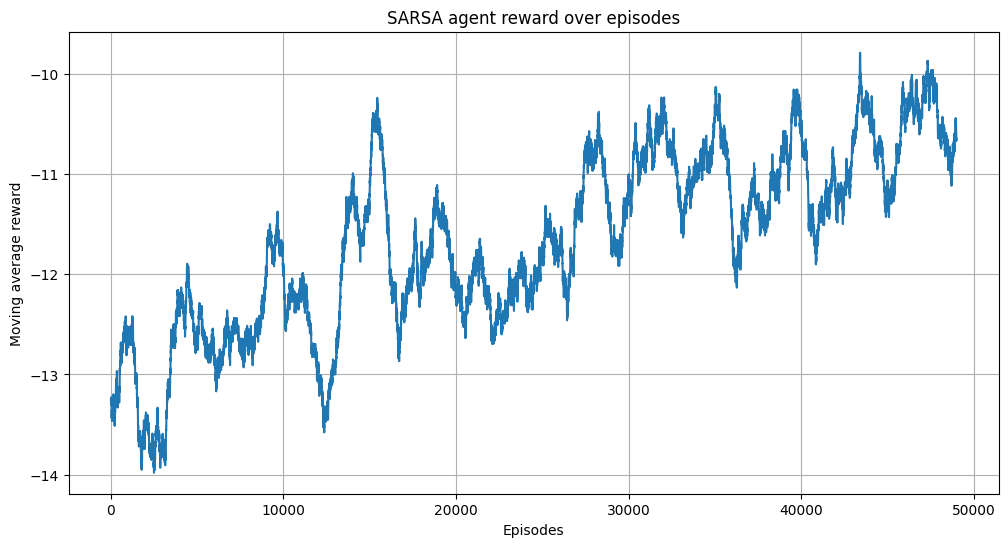

In [ ]:
# Plot average reward
plot_rewards(rewards_all_episodes, 'SARSA agent reward over episodes')

This plot shows the learning progress of the agent over all the episodes in a "random attack" scenario. The agent is in fact learning, even if in a high-variance environment.

The most important takeaway is that the **moving average reward** is trending upward. It starts around 3000 and climbs toward  by the end of the training. This indicates that the agent is effectively updating its Q-values to prioritize actions that mitigate the impact of the random attacks or maximize defensive efficiency.

But there is also a lot of "instability". Considering the context of the simulation (cybersecurity), and being SARSA an **on-policy** algorithm, lead us to think that this high variance can be due to the actions that the agent *actually* takes, including exploratory (random) moves.

The agent seems to reach a "plateau" area between episodes 45000 and 50000. While the trend is still slightly positive, the rewards are bouncing within a specific band (-10 to -11.5).

In conlcusion, the agent has perfected its policy over the episodes, but it hasn't "solved" the environment perfectly (likely because a "random attack" implies some unavoidable loss/cost), but it has reached a steady state of performance.

---

# DDQN
The **DDQN (Double Deep Q-Network)** is an advanced deep reinforcement learning algorithm designed to fix a specific flaw in the original Deep Q-Network (DQN).

### 1. The core problem: overestimation bias

In standard DQN, the agent often overestimates the value of certain actions. This happens because the same network is used to both **select** an action and **estimate its value**. If a random error makes an action look better than it is, DQN will "greedily" lock onto that error, leading to poor learning stability.

### 2. The solution: decoupling selection and evaluation

DDQN solves this by using two separate neural networks to handle the update:

* **The policy network (online network):** this network decides **which action** is the best to take.
* **The target network:** this network calculates the **value (Q-value)** of that specific action.

By separating these tasks, if the Policy Network accidentally picks a "bad" action due to noise, the Target Network (which has older, more stable weights) is likely to provide a more realistic, lower value for it, effectively "canceling out" the overestimation.

### 3. The DDQN update rule

The mathematical difference lies in the Target calculation ($Y_t$):

$$Y_t^{DoubleDQN} = R_{t+1} + \gamma Q(S_{t+1}, \text{argmax}_{a} Q(S_{t+1}, a; \theta_t); \theta_t^{-})$$

Where:

* $\theta_t$: the weights of the **online network** (used to pick the action).
* $\theta_t^{-}$: the weights of the **target network** (used to evaluate that action).
* In contrast, standard DQN uses $\theta_t^{-}$ for both steps.

### 4. Key advantages

* **Stability:** DDQN provides more stable and reliable learning curves compared to DQN.
* **Accuracy:** it results in more accurate value estimates, which leads to better final policies.
* **Complexity:** unlike SARSA, which uses a simple table, DDQN uses Neural Networks, allowing it to handle "high-dimensional" states (like images or complex network logs).

Now let's initialize the scenario in which the algorithm will operate.

According to the documentation the latest version of the gym-idsgame environment for testing both "random attack" and "maximal attack" scenarios is the 21.

In [ ]:
# Using a "random attack" environment
env_name = 'idsgame-random_attack-v21'
random_attack_env = gym.make(env_name)

In [ ]:
# Using a "maximal attack" environment
env_name = 'idsgame-maximal_attack-v21'
maximal_attack_env = gym.make(env_name)

Then let's define the hyperparameters for the DDQN reinforcement learning algorithm. These parameters control the training process and the agent's learning behavior:

* **episodes:** set to 50,000, this is the total number of training iterations, or "games", the DDQN agent will play.
* **max_steps:** this is 100, representing the maximum number of actions the agent can take within a single episode, preventing endless loops.
* **epsilon:** starting at 1.0, this is the initial exploration rate. It means the agent will initially choose random actions frequently to explore the environment.
* **epsilon_decay:** set to 0.9995, this factor gradually reduces the epsilon value after each episode, transitioning the agent from exploration to exploitation.
* **epsilon_end:** the minimum exploration rate, set to 0.01. The agent will always retain a small chance of random action for continuous exploration.
* **gamma (discount factor):** valued at 0.99, it determines the importance of future rewards. A high value means the agent considers long-term rewards significantly.
* **tau:** at 0.001, this parameter is used for the soft update of the target Q-network. It controls how slowly the target network's weights update towards the local network's weights, ensuring training stability.
* **learning_rate:** set to 0.0005, this is the step size used by the Adam optimizer when updating the neural network weights based on the calculated loss.
* **upd_freq:** this is 4, meaning the local Q-network will be updated every 4 steps, after accumulating enough experiences in the replay buffer.
* **buffer_size:** with a value of 100,000, this is the maximum number of past experiences (state, action, reward, next state, done) stored in the replay memory for learning.
* **batch_size:** set to 64, this is the number of experiences randomly sampled from the replay buffer to train the neural network in each learning step.

In [ ]:
# Hyperparameters definition
episodes = 50000
max_steps = 100

epsilon = 1.0
epsilon_decay = 0.9995
epsilon_end = 0.01

gamma = 0.99
tau = 0.001

learning_rate = 0.0005

upd_freq = 4

buffer_size = 100000
batch_size = 64

## Random attack scenario

In [ ]:
# DDQN training on random attack scenario
random_attack_rewards, random_attack_losses = train_ddqn_agent(random_attack_env, episodes, max_steps, epsilon,
                                                               gamma, learning_rate, epsilon_decay, epsilon_end,
                                                               tau, upd_freq, buffer_size, batch_size)

DDQN agent training on maximal attack scenario

Episode: 1000/50000
Avg reward: -13.1662
Episode: 2000/50000
Avg reward: -13.4140
Episode: 3000/50000
Avg reward: -13.2060
Episode: 4000/50000
Avg reward: -11.5440
Episode: 5000/50000
Avg reward: -9.7750
Episode: 6000/50000
Avg reward: -10.0100
Episode: 7000/50000
Avg reward: -9.1260
Episode: 8000/50000
Avg reward: -9.2040
Episode: 9000/50000
Avg reward: -8.5020
Episode: 10000/50000
Avg reward: -9.9320
Episode: 11000/50000
Avg reward: -8.5280
Episode: 12000/50000
Avg reward: -7.8520
Episode: 13000/50000
Avg reward: -8.0080
Episode: 14000/50000
Avg reward: -7.6700
Episode: 15000/50000
Avg reward: -7.4360
Episode: 16000/50000
Avg reward: -7.5660
Episode: 17000/50000
Avg reward: -7.8520
Episode: 18000/50000
Avg reward: -6.5260
Episode: 19000/50000
Avg reward: -7.6180
Episode: 20000/50000
Avg reward: -7.6180
Episode: 21000/50000
Avg reward: -7.5660
Episode: 22000/50000
Avg reward: -7.1500
Episode: 23000/50000
Avg reward: -7.2540
Episode: 2400

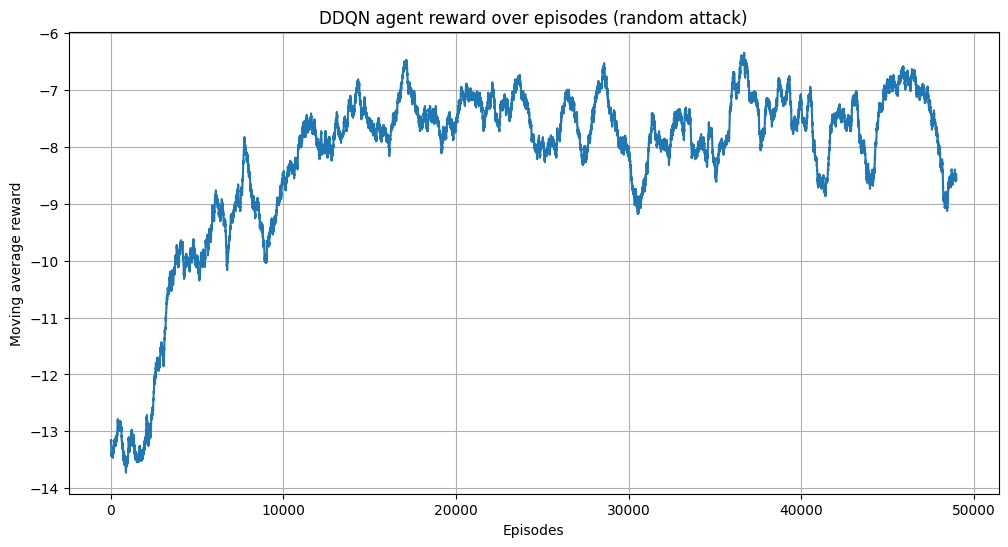

In [ ]:
# Plot rewards
plot_rewards(random_attack_rewards, 'DDQN agent reward over episodes (random attack)')

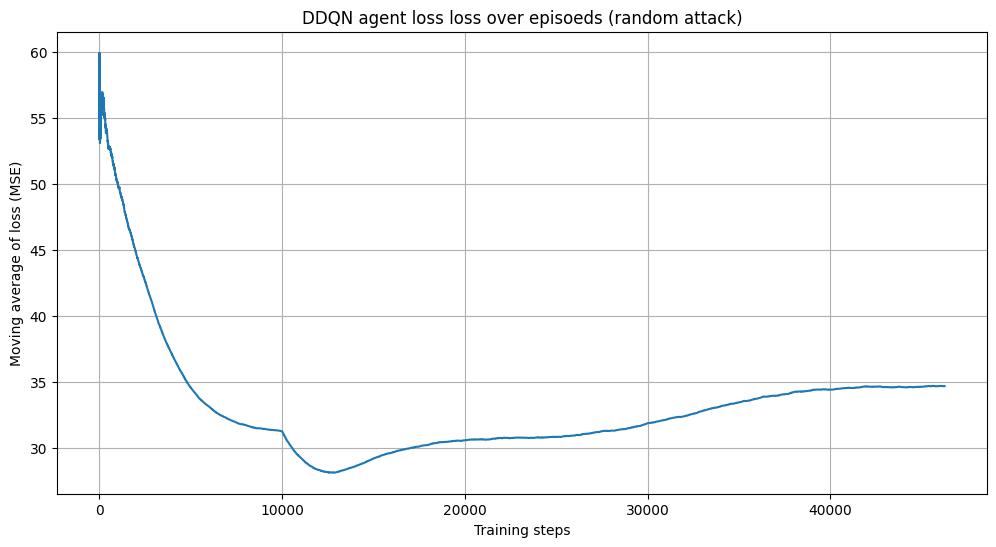

In [ ]:
# Plot loss
plot_loss(random_attack_losses, 'DDQN agent loss loss over episoeds (random attack)')

These plots tell a story of an agent that quickly learns a defensive strategy, but eventually hits a performance ceiling due to the unpredictable nature of "random attacks."

The reward evolution plot shows the actual "success" of the agent in the environment.

* **Discovery phase (0 – 3,000 episodes):** the agent performs poorly, with rewards fluctuating between -13 and -14. It is essentially taking random actions and failing to mitigate the attack.
* **The breakthrough (~3,000 – 7,000 episodes):** there is a steep, positive slope here. This is the moment where the DDQN identifies which defensive actions correlate with lower penalties.
* **Oscillatory plateau (10,000 – 50,000 episodes):** the reward stabilizes in a range between -6.5 and -9. The "sawtooth" pattern in the plateau suggests that while the agent is competent, it hasn't found a "perfect" solution. Because the attack is **random**, the agent sometimes gets "lucky" with its defense and sometimes fails, leading to these constant cycles of performance.

The loss represents the **Mean Squared Error (MSE)** between the predicted Q-values and the target Q-values (the Bellman equation).

* **Initial volatility (0 – 1,000 steps):** there is a massive initial spike followed by a rapid drop. This is standard behavior as the agent’s replay buffer starts filling up and the neural network begins to find a gradient to follow.
* **The learning process (~10,000 steps):** a noticeable sharp drop occurs at exactly 10,000 steps. This behavior is due to the hyperparameter that trigger the point where the *epsilon-greedy exploration* reaches its minimum value.
* **Long-term stability:** after 12,000 steps, the loss doesn't drop to zero; instead, it stabilizes and actually shows a very slight upward drift toward the end (settling around 35). A non-zero, stable loss is a good sign in reinforcement learning. It indicates the agent is still learning and adapting to new states, but the "error" is consistent, meaning the network isn't diverging or collapsing.

In terms of general performance, the DDQN agent's training was highly successful in its convergence, as both the loss and reward plots show it reaching a steady state after approximately 15,000 to 20,000 iterations. The learning efficiency is notably high, with the agent requiring only a small number of episodes relative to the total run to transition from a "fail" state to effective attack mitigation.

While the agent's robustness is considered moderate, as it reduces the cost of the random attack by roughly 50% (moving from a reward of -13 to approximately -7), it demonstrates high stability. The DDQN architecture successfully prevents the "overestimation bias" typically found in standard DQN models, which is evident by the lack of any sudden or catastrophic drops in performance once the agent has learned its strategy.

## Maximal attack scenario

In [ ]:
# DDQN training on random attack scenario
maximal_attack_rewards, maximal_attack_losses = train_ddqn_agent(maximal_attack_env, episodes, max_steps, epsilon,
                                                               gamma, learning_rate, epsilon_decay, epsilon_end,
                                                               tau, upd_freq, buffer_size, batch_size)

DDQN agent training on maximal attack scenario

Episode: 1000/50000
Avg reward: -15.7177
Episode: 2000/50000
Avg reward: -16.0670
Episode: 3000/50000
Avg reward: -13.0980
Episode: 4000/50000
Avg reward: -10.8350
Episode: 5000/50000
Avg reward: -8.4610
Episode: 6000/50000
Avg reward: -7.9020
Episode: 7000/50000
Avg reward: -5.6150
Episode: 8000/50000
Avg reward: -3.9510
Episode: 9000/50000
Avg reward: -3.0160
Episode: 10000/50000
Avg reward: -1.4800
Episode: 11000/50000
Avg reward: -1.1960
Episode: 12000/50000
Avg reward: -1.1440
Episode: 13000/50000
Avg reward: -1.3520
Episode: 14000/50000
Avg reward: -1.2220
Episode: 15000/50000
Avg reward: -0.9880
Episode: 16000/50000
Avg reward: -0.9360
Episode: 17000/50000
Avg reward: -0.9100
Episode: 18000/50000
Avg reward: -0.7530
Episode: 19000/50000
Avg reward: -0.3640
Episode: 20000/50000
Avg reward: -1.1180
Episode: 21000/50000
Avg reward: -1.0920
Episode: 22000/50000
Avg reward: -2.1580
Episode: 23000/50000
Avg reward: -5.8760
Episode: 24000

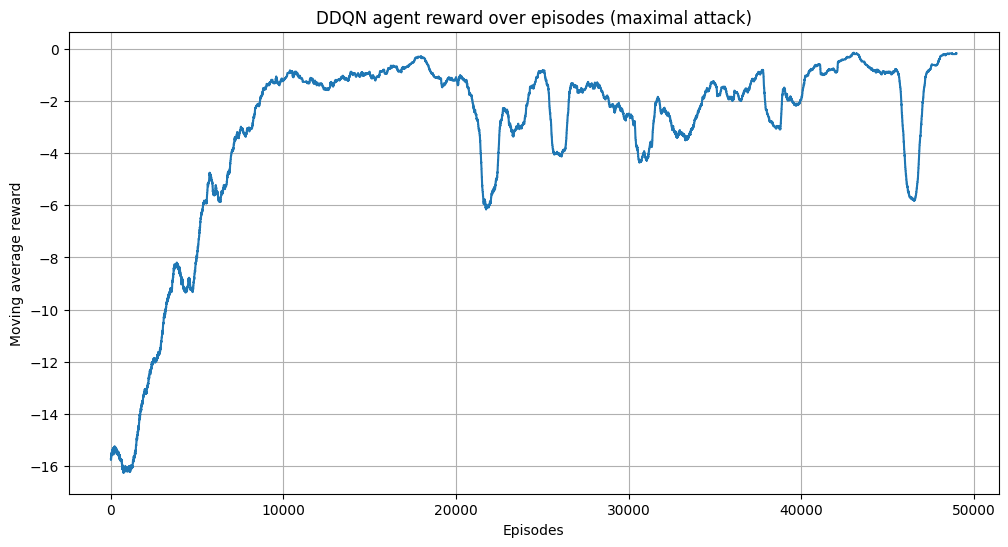

In [ ]:
# Plot reward
plot_rewards(maximal_attack_rewards, 'DDQN agent reward over episodes (maximal attack)')

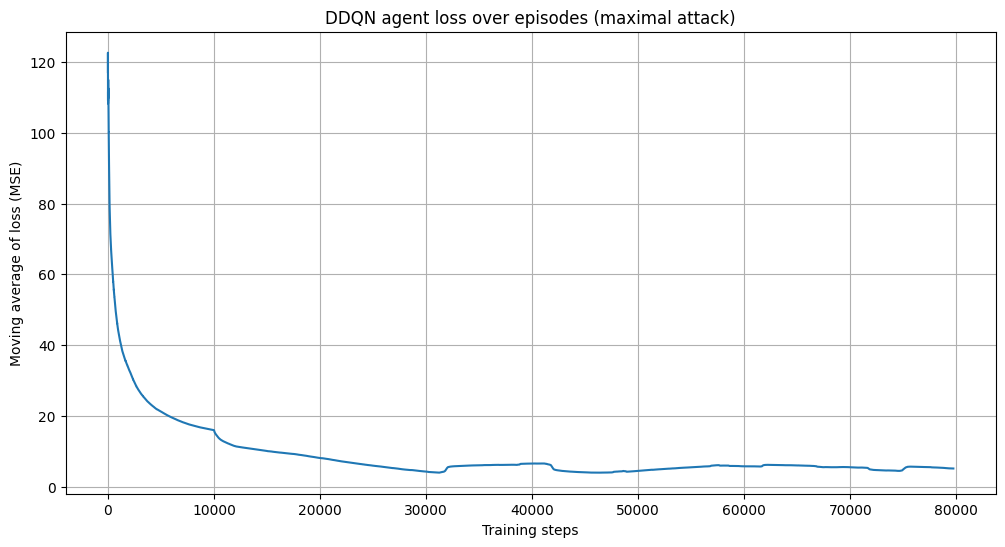

In [ ]:
# Plot loss
plot_loss(maximal_attack_losses, 'DDQN agent loss over episodes (maximal attack)')

Thiese plots presents a much more intense training dynamic than the random attack one. While the agent achieves higher peaks of performance, it also faces significantly more instability.

The reward evolution plot is the most revealing. It shows an agent that reaches "near-perfection" but struggles to maintain it.

* **Rapid learning (0 – 10,000 episodes):** the agent climbs from a low of -16 to nearly 0. This is a much better peak than the random attack scenario (which peaked at -6.5). It shows the agent learned a near-perfect defense.
* **The "golden period" (10,000 – 22,000 episodes):** for a long stretch, the agent maintains a reward close to 0. In cybersecurity terms, this means it is successfully neutralizing almost every aspect of the maximal attack.
* **Periodic collapses (22,000+ episodes):** After the 22k mark, we see **sharp, deep plunges** in reward (dropping down to -6). This is a classic sign of **"catastrophic forgetting"**. Because the attack is "maximal" (likely targeting specific vulnerabilities), if the agent's policy shifts slightly to optimize one area, it may suddenly leave a "hole" elsewhere that the maximal attack exploits ruthlessly. Each drop is followed by a sharp recovery, showing the agent is capable of re-learning, but the cycle repeats.

The loss curve here is quite different from the random scenario, showing both higher initial difficulty and better final convergence.

* **Initial complexity:** the loss starts much higher (around **120 MSE**) compared to the random attack (~60 MSE). This indicates that a "maximal" attack creates a much more complex state space for the agent to understand initially.
* **Superior convergence:** despite the higher start, the loss drops significantly lower, settling **below 10** after 30,000 steps. This suggests that the "maximal attack" follows a more deterministic or "logical" pattern than the random one. The DDQN has successfully "mapped" the attacker's optimal strategy and can predict the necessary counter-moves with very high precision (low error).
* **Step-wise Refinement:** it's possible to see distinct "steps" or plateaus (e.g., at 30k and 40k steps). These likely correspond to the agent discovering specific counter-measures for different phases or types of the maximal attack.

The agent’s general performance presents a high-risk, high-reward profile. The **peak performance** is **exceptional**, as the agent reaches reward levels near zero, which is significantly better than its performance during random attacks. This is supported by a **very high loss accuracy**, where a much lower MSE indicates that the agent has developed a superior understanding of the environment's underlying patterns.

However, the **stability** of the agent in this scenario is **low**. While it can achieve near-perfection, it remains prone to sudden, massive performance failures after the 22,000-episode mark. Despite this volatility, the agent demonstrates **high strategic capability**, as it successfully identifies an optimal defense strategy for a complex, aggressive environment, even if that solution proves fragile over long periods.

## Comparison: random attack vs. maximal attack

In the **random attack scenario**, the agent was "consistently mediocre". It couldn't get a high reward because the noise was too high, but it stayed stable.

In the **maximal attack scenario**, the agent is "brilliantly unstable." It finds the perfect defense (reward ~0), but because the attack is so aggressive, any small error in the agent's neural network weights results in a massive penalty.

---

# Conclusions

Here is the conclusion based on the data from the various training scenarios. It compares both SARSA and DDQN agent's performance across different attack profiles.

The experimental results demonstrate that while deep reinforcement learning (DDQN) significantly outperforms traditional reinforcement learning (SARSA) in defensive capability, the complexity of the attack profile creates a distinct trade-off between stability and peak performance.

### The SARSA baseline: limited complexity handling

The **SARSA agent** exhibits the lowest overall performance among the tested models. Starting at a moving average reward of approximately -14, it shows a slow, marginal improvement over 50,000 episodes, eventually fluctuating between -10 and -11.

The SARSA agent lacks the representational power to fully "solve" the environment, as it never reaches the higher reward thresholds achieved by the DDQN agents.

Its high local volatility and slow learning curve suggest that a tabular or linear approach is insufficient for the high-dimensional state spaces typical of cybersecurity simulations.

### DDQN under random attack: consistent reliability

The **DDQN agent under random attacks** demonstrates high stability and efficient convergence.

It quickly transitions from a reward of -13.5 to a stable plateau around -7 within the first 15,000 episodes.

Its loss evolution is remarkably consistent after the initial discovery phase, suggesting it has successfully learned a "best-average" defensive policy.

This agent is a reliable defender. While it cannot reach a perfect reward of 0 due to the unpredictable nature of random noise, it provides a consistent and robust baseline defense.

### DDQN under maximal attack: high performance, high fragility

The **DDQN agent under maximal attack** represents the "specialist" model. It achieves the highest peak performance of all tests, frequently reaching a reward near 0 between 10,000 and 22,000 episodes.
The extremely low final Mean Squared Error (MSE) indicates that the agent has developed a near-perfect internal model of the attacker's optimal strategy.
* **Fragility:** However, this model is prone to "catastrophic forgetting" or policy shifts, evidenced by sharp, periodic plunges in reward down to -7 in the later stages of training.
* **Verdict:** While this agent is the most capable of neutralizing sophisticated threats, its tendency toward sudden instability makes it a riskier choice for autonomous deployment without further regularization.

### Final summary

The **DDQN architecture** is clearly superior to **SARSA** for this task, providing better mitigation in both attack scenarios. For general resilience, the "random attack" training profile yields the most **stable** results, whereas the "maximal attack" profile yields the most **effective** results at the cost of long-term consistency.